In [2]:
from operators import *
from backtest import *
import pandas as pd
import numpy as np
import os
import glob
from typing import Iterable
#import alphalens as als
import quantstats as qs
import pickle
import seaborn as sns
import matplotlib.pyplot as mp
from functools import reduce

qs.extend_pandas()

target_folder_path = rf'/Users/tedting/Documents/Alpha/data'
%cd "{target_folder_path}"

/Users/tedting/Documents/Alpha/data


### 20240105

In [5]:
adj_open = pd.read_pickle(rf'{target_folder_path}/adj_open.pkl')
#exp_returns = adj_open.pct_change().shift(-2)
adj_open = adj_open[adj_open.columns.intersection(F_symbol)]
exp_returns = adj_open.pct_change().shift(-2)

Close = pd.read_pickle(rf'{target_folder_path}/收盤價(元).pkl')
Close = Close[Close.columns.intersection(F_symbol)]

Volume = pd.read_pickle(rf'{target_folder_path}/成交量(千股).pkl')
Volume = Volume[Volume.columns.intersection(F_symbol)]

Limit = pd.read_pickle(rf'{target_folder_path}/limit.pkl')
ZTXA = pd.read_pickle(rf'{target_folder_path}/ZTXA_close.pkl')
Benchmark = ZTXA['ZTXA 台指近月期貨指數'].pct_change().shift(-2)

In [6]:
投信持股率 = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/data/data_daily/投信持股率%.pkl')
投信持股率 = 投信持股率[投信持股率.columns.intersection(F_symbol)]
GrossProfitGrowthRate = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/OFFICIAL_data_2/GrossProfitGrowthRate_q_90%.pkl')
GrossProfitGrowthRate = GrossProfitGrowthRate[GrossProfitGrowthRate.columns.intersection(F_symbol)]
REV_G_m = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/OFFICIAL_data_2/REV_G_m_90%.pkl')
REV_G_m = REV_G_m[REV_G_m.columns.intersection(F_symbol)]

# W_GrossProfitGrowthRate = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/OFFICIAL_data_2/W_GrossProfitGrowthRate.pkl')
# W_REV_G_m = pd.read_pickle(rf'/Users/tedting/Documents/Alpha/OFFICIAL_data_2/W_REV_G_m.pkl')

In [7]:
Volume_y_avg = Volume.rolling(252).mean()
Close_y_avg = Close.rolling(252).mean()
heavy_Filter = Close_y_avg < 1000 
Volume_Filter = Volume_y_avg > 200
trade_volume_Filter = Close_y_avg * Volume_y_avg > 60000
small_aum_Filter = Volume_Filter & trade_volume_Filter
small_aum_Filter_L = Volume_Filter & trade_volume_Filter & Limit

In [13]:
def weight(alpha:pd.DataFrame, strategy = 'LS'):
    demean = alpha.sub(alpha.mean(axis = 1), axis = 0)
    weight = demean.div(demean.abs().sum(axis = 1), axis = 0) # 有浮點數問題待解決

    # 多、空或多空
    if strategy == 'LS':
        weight = weight
    elif strategy == 'LO':
        weight = weight[weight > 0]*2
    elif strategy == 'SO':
        weight = weight[weight < 0]*2
    else:
        raise ValueError("Please use 'LS', 'LO', or 'SO' in strategy")
    weight = weight.fillna(0)
    return weight # pd.DataFrame

# def LS_rank_neutrolize(df:np.array)-> np.array:
#     for index, row in df.iterrows():
#         ranked_values = pd.Series(row.values).rank()
#         pct_values = [(v - min(ranked_values)) / (max(ranked_values) - min(ranked_values)) for v in ranked_values]
#         pct_values = pd.Series(pct_values)
#         neutrolized_value = pct_values -0.5
#         x = pd.DataFrame(neutrolized_value)
#     return(x) # can't get the correct answer

def fee(alpha:pd.DataFrame, 
        strategy = 'LS', 
        buy_fee:float = 0.001425*0.3, 
        sell_fee:float = 0.001425*0.3+0.003, 
        start_time='2014-01-01',
        end_time='2023-08-11'):
    weights = weight(alpha, strategy = strategy).loc[start_time:end_time]
    delta_weight = weights.shift(1) - weights
    buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
    buy_fees = buy_fees.fillna(0)
    sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
    sell_fees = sell_fees.fillna(0)
    fee = buy_fees + sell_fees
    daily_fee = fee.sum(axis = 1)
    return daily_fee # pd.Series

def bt(filename,filename2,alpha:pd.DataFrame,
       expreturn:pd.DataFrame, 
       strategy='LS', 
       buy_fee:float=0.001425*0.3, sell_fee:float=0.001425*0.3+0.003,
       start_time='2014-01-01',
       end_time='2023-08-11'):
    daily_weight = weight(alpha, strategy = strategy).loc[start_time:end_time]
    expreturn = expreturn.loc[start_time:end_time]
    daily_fee = fee(alpha, buy_fee=buy_fee, sell_fee=sell_fee, start_time=start_time, end_time=end_time)
    daily_profit = (daily_weight * expreturn).sum(axis=1)
    daily_returns = daily_profit - daily_fee
    
    basename = os.path.basename(filename)
    basename2 = os.path.basename(filename2)
    summary_df = pd.DataFrame({
    'Filename': rf'{basename}-{basename2}',
    'Sharpe Ratio':[sharpe(daily_returns)],
    'Annualized Ret': [annual_returns(daily_returns)],
    'Max Drawdown':[MDD(daily_returns)],
    'Turnover':[turnover(alpha)], 
    'Std':[daily_returns.std()],
    'IC':[IC(alpha, expreturn, start_time, end_time)],
    'IR':[IR(alpha, expreturn, start_time, end_time)]# 這邊的input不同要注意
    }, index = ['Performance'])
    return daily_returns, summary_df # pd.DataFrame

# Index

def sharpe(daily_returns:pd.Series):
    Sharpe_ratio = round(daily_returns.mean()/daily_returns.std()*252**0.5,4)
    return Sharpe_ratio 

def annual_returns(daily_returns:pd.Series):
    LS_compound = (daily_returns+1).cumprod()
    days = len(LS_compound)
    total_return = LS_compound.iloc[-1]/LS_compound.iloc[0]-1
    annual_returns =  (total_return + 1)**(252/days) - 1
    return annual_returns

def turnover(alpha:pd.DataFrame):
    delta_weight = weight(alpha).shift(1) - weight(alpha)
    daily_tradingvalue = delta_weight.abs().sum(axis = 1)
    turnover = daily_tradingvalue.sum()/len(daily_tradingvalue)
    return turnover

def MDD(daily_returns:pd.Series):
    LS_compound = (daily_returns+1).cumprod()
    drawdowns = []
    peak = LS_compound[0]
    for price in LS_compound:
        if price > peak:
            peak = price
        drawdown = (price - peak) / peak
        drawdowns.append(drawdown)
    max_drawdown = np.min(drawdowns)
    return abs(max_drawdown)

def IC(alpha:pd.DataFrame, expreturn:pd.DataFrame, start_time='2014-01-01', end_time='2023-08-11'):
    f = alpha.loc[start_time:end_time]  # t期因子值
    r = expreturn.loc[start_time:end_time]  # t+1期股票实际收益率
    ic = f.corrwith(r, axis=1)
    return(ic.mean())

def IR(alpha:pd.DataFrame, expreturn:pd.DataFrame, start_time='2014-01-01', end_time='2023-08-11'):
    f = alpha.loc[start_time:end_time]  # t期因子值
    r = expreturn.loc[start_time:end_time]  # t+1期股票实际收益率
    ic = f.corrwith(r, axis=1)
    ir = ic.mean()/ic.std()
    return(ir)

In [36]:
dfs = [W_GrossProfitGrowthRate,
       W_REV_G_m
       ]

# 使用 reduce 進行累加
result_df = reduce(lambda x, y: x.add(y, fill_value=0), dfs)
result_df = result_df[small_aum_Filter]
stocks = 10
top = result_df.apply(lambda row: row.nlargest(stocks), axis=1).fillna(0)
top_equalweight = top.applymap(lambda x: 1/stocks if x != 0 else 0)
test = top_equalweight.sum(axis =1)
for index, value in test.items():
    if (0.001 < value < 0.995) or (-0.001 > value > -0.995):
        print(f"Error at index {index}: value is {value}")
buy_fee:float=0.001425*0.3
sell_fee:float=0.001425*0.3+0.003
start_time = '2014-05-09' # '2014-05-09'
end_time = '2023-11-30'
# expreturn = exp_returns.loc[start_time:end_time]
# weight = result_df.loc[start_time:end_time]
weight = top_equalweight.loc[start_time:end_time]
expreturn = exp_returns .loc[start_time:end_time]
delta_weight = weight.shift(1) - weight
buy_fees = delta_weight[delta_weight > 0]*(buy_fee)
buy_fees = buy_fees.fillna(0)
sell_fees = delta_weight.abs()[delta_weight < 0]*(sell_fee)
sell_fees = sell_fees.fillna(0)
fee = buy_fees + sell_fees
daily_fee = fee.sum(axis = 1)
daily_profit = (weight * expreturn).sum(axis=1)
daily_returns_財務因子 = daily_profit - daily_fee

/var/folders/fx/jn0gghjd4cg68lr15nlpsbqr0000gn/T/ipykernel_13884/3079945774.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top_equalweight = top.applymap(lambda x: 1/stocks if x != 0 else 0)


/Users/tedting/Documents/Alpha/backtest.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak = LS_compound[0]


/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass ax

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-05-09  2014-05-09
End Period                 2023-11-30  2023-11-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          20.82%      96.98%
CAGR﹪                     2.0%        7.34%

Sharpe                     0.41        0.52
Prob. Sharpe Ratio         89.38%      94.24%
Smart Sharpe               0.39        0.5
Sortino                    0.6         0.72
Smart Sortino              0.57        0.69
Sortino/√2                 0.42        0.51
Smart Sortino/√2           0.41        0.49
Omega                      1.07        1.07

Max Drawdown               -14.8%      -31.51%
Longest DD Days            1220        748
Volatility (ann.)          5.33%       16.61%
R^2                        0.04        0.04
Information Ratio          -0.03       -0.03
Calmar                     0.13        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-07-28,2023-01-04,2023-11-30,1220,-14.800273,-14.560610
2,2016-08-31,2017-04-11,2018-04-13,590,-10.481758,-9.949475
3,2018-07-12,2018-11-22,2020-02-11,579,-8.427444,-8.227288
4,2015-08-24,2015-10-16,2016-05-30,280,-7.044599,-6.884803
5,2014-06-05,2014-12-31,2015-04-01,300,-4.167145,-4.076614


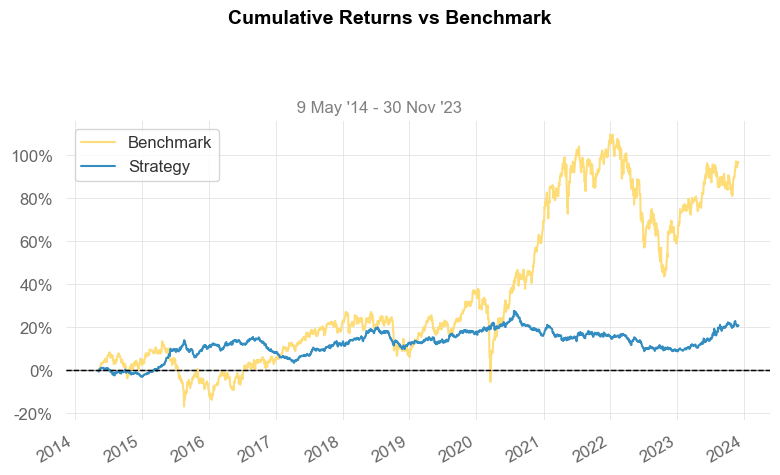

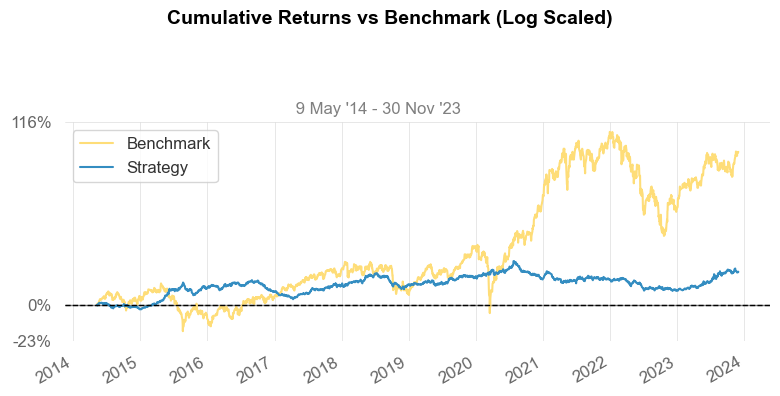

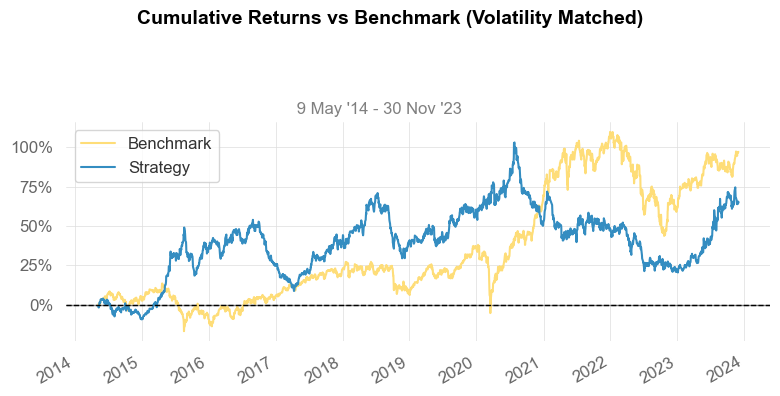

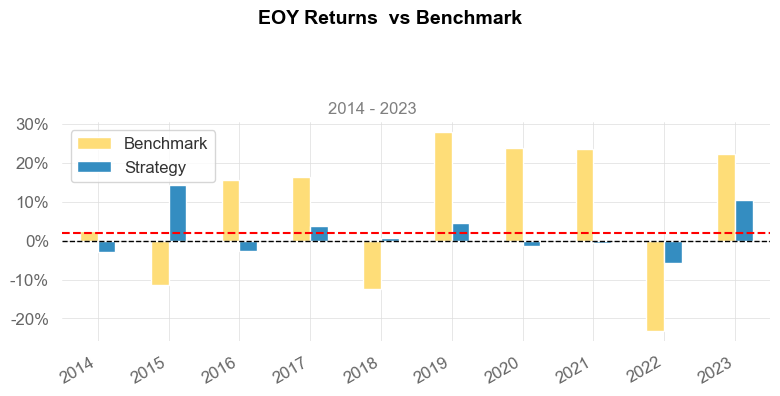

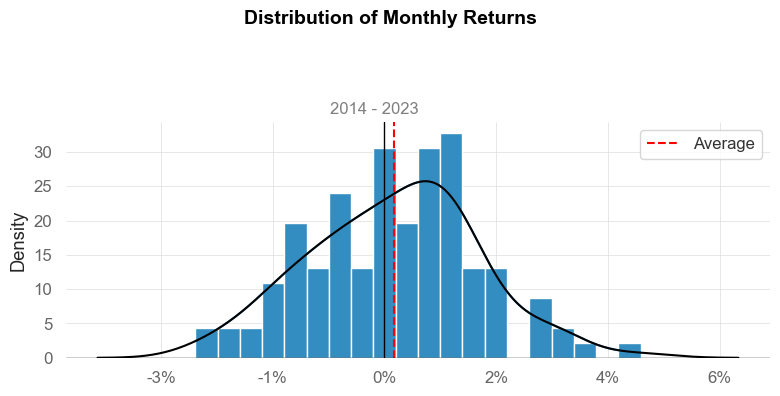

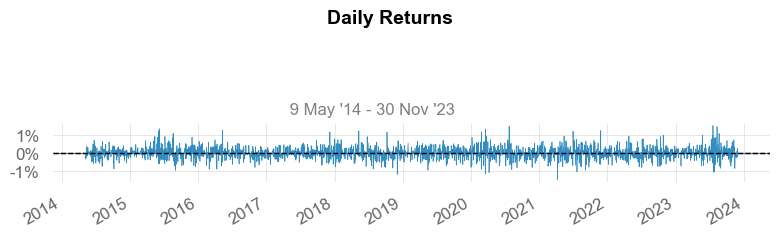

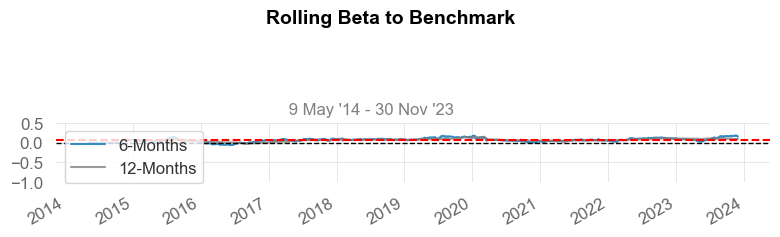

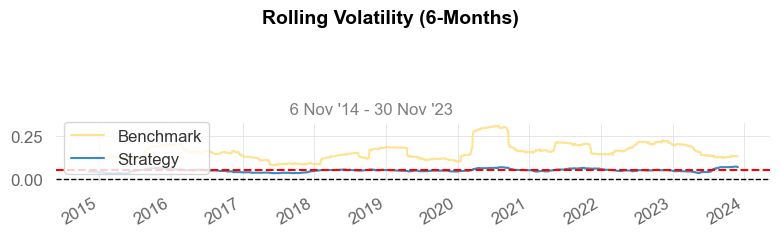

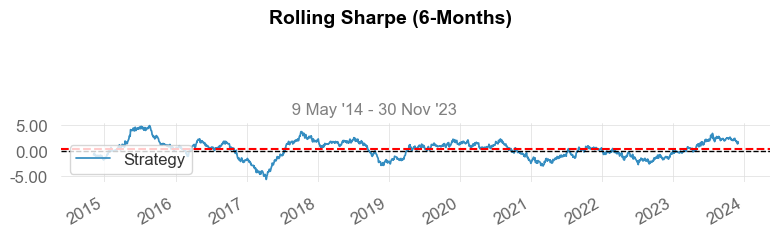

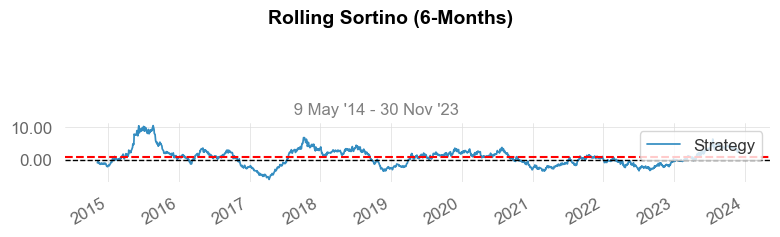

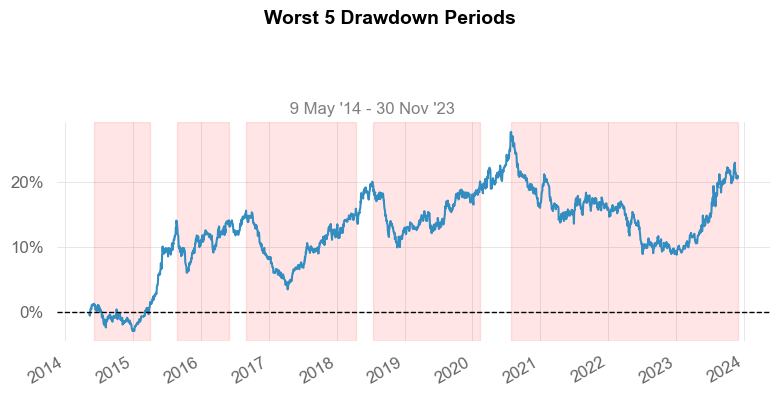

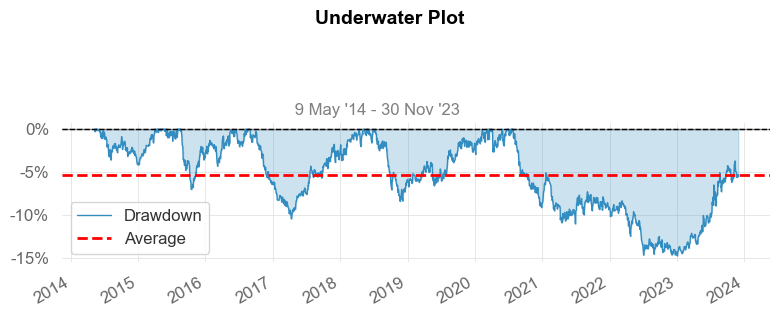

TypeError: pivot() takes 1 positional argument but 4 were given

In [12]:
# alpha = eval(f'ts_rank((REV_G_m),252)')[small_aum_Filter2]
# daily_returns, result_summary = bt(alpha, exp_returns,
#                             strategy='LO',
#                             buy_fee=0.001425*0.3, sell_fee=0.001425*0.3+0.003,
#                             start_time='2013-06-01',
#                             end_time='2023-11-30')
# # final_summary = pd.concat([final_summary, result_summary], axis=0, ignore_index=True)
# correlation_matrix = pd.concat([correlation_matrix, daily_returns], axis=1, ignore_index = False)
# ts_regression(y: pd.DataFrame, x: pd.DataFrame, d: int, rettype: int = 0)
alpha = eval(f'cs_rank(投信持股率)')[small_aum_Filter]
daily_returns_投信, result_summary = bt(alpha, exp_returns,
                            strategy='LS',
                            buy_fee=0.001425*0.3, sell_fee=0.001425*0.3+0.003,
                            start_time = '2014-05-09',
                            end_time = '2023-11-30')
# final_summary = pd.concat([final_summary, result_summary], axis=0, ignore_index=True)
#correlation_matrix = pd.concat([correlation_matrix, daily_returns], axis=1, ignore_index = False)

qs.reports.full(daily_returns_投信, Benchmark)

/Users/tedting/Documents/Alpha/backtest.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak = LS_compound[0]


/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass ax

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-05-09  2014-05-09
End Period                 2023-11-30  2023-11-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          86.0%       96.98%
CAGR﹪                     6.7%        7.34%

Sharpe                     1.39        0.52
Prob. Sharpe Ratio         100.0%      94.24%
Smart Sharpe               1.36        0.51
Sortino                    2.07        0.72
Smart Sortino              2.03        0.71
Sortino/√2                 1.47        0.51
Smart Sortino/√2           1.44        0.5
Omega                      1.25        1.25

Max Drawdown               -9.9%       -31.51%
Longest DD Days            617         748
Volatility (ann.)          4.9%        16.61%
R^2                        0.0         0.0
Information Ratio          -0.01       -0.01
Calmar                     0.68        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-09-28,2023-08-22,2023-11-30,428,-9.897877,-9.748206
2,2018-07-12,2018-11-29,2020-03-20,617,-7.087660,-6.607105
3,2016-01-27,2016-04-11,2016-08-05,191,-3.851350,-3.762089
4,2021-01-07,2021-01-21,2021-02-26,50,-2.799192,-2.316092
5,2021-12-24,2022-03-14,2022-04-26,123,-2.792569,-2.509143


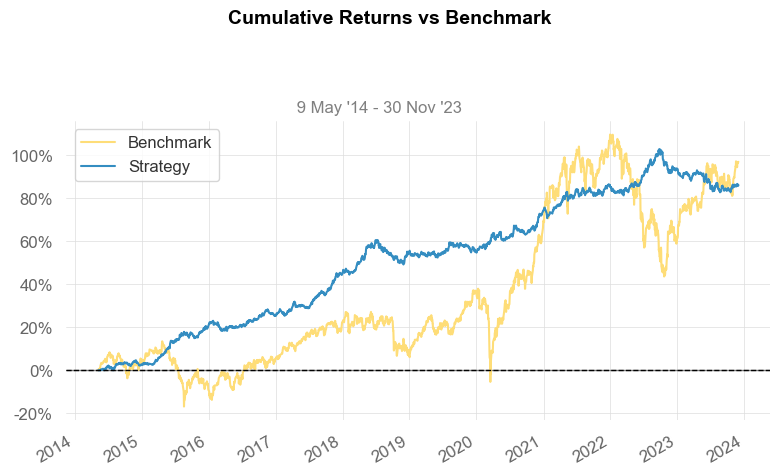

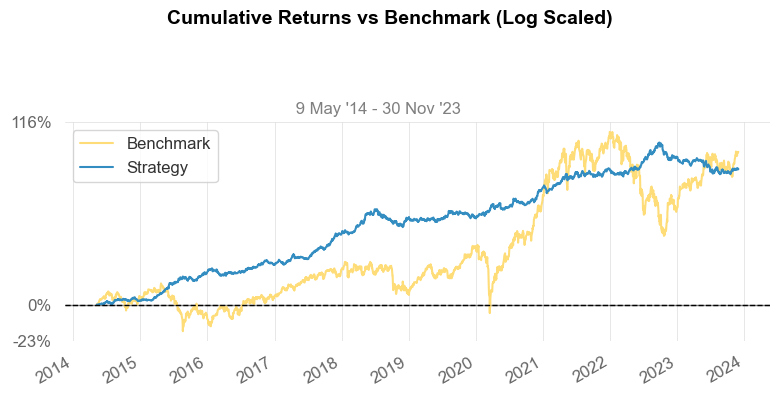

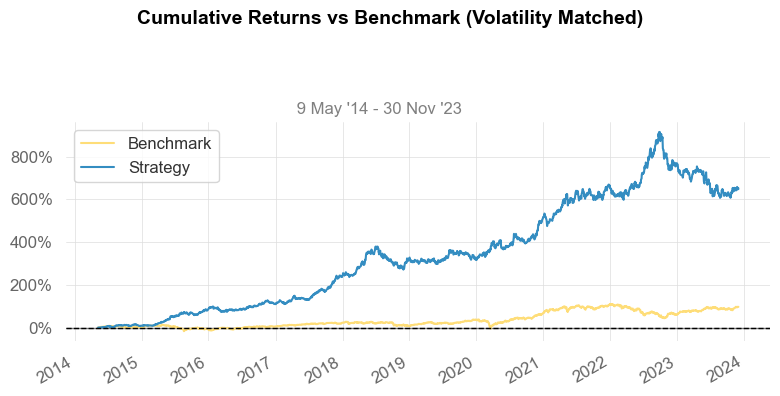

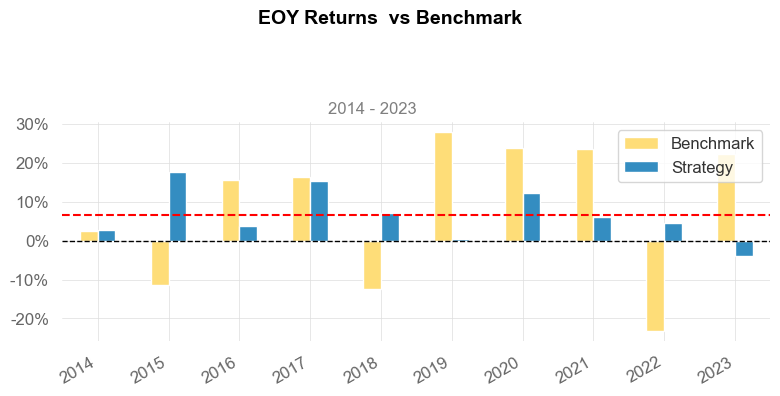

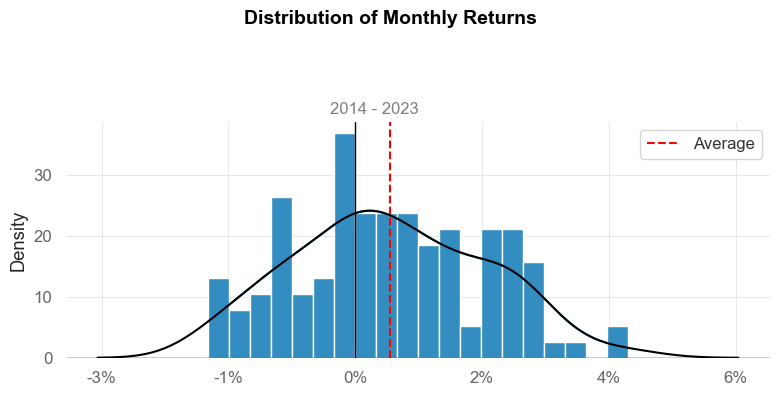

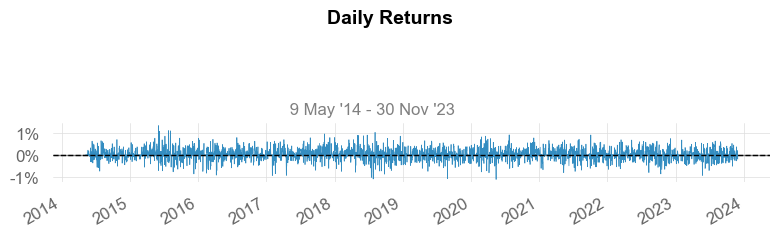

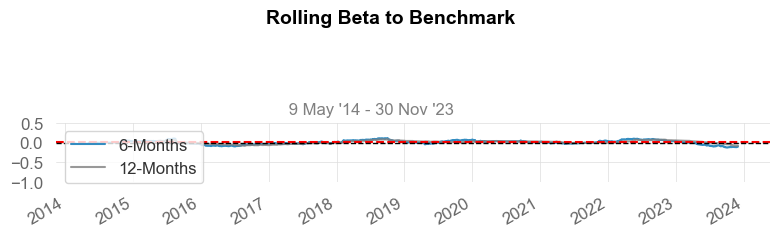

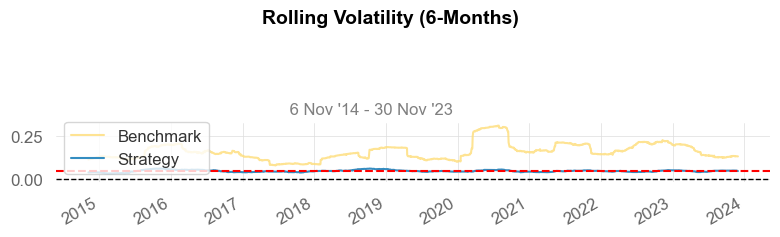

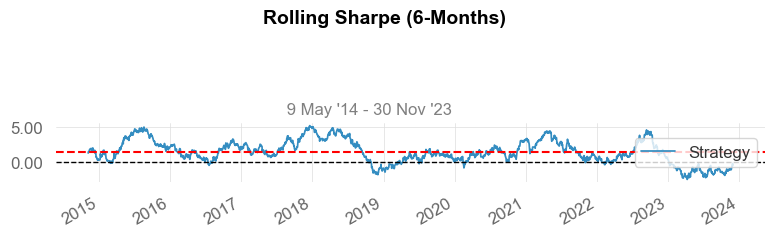

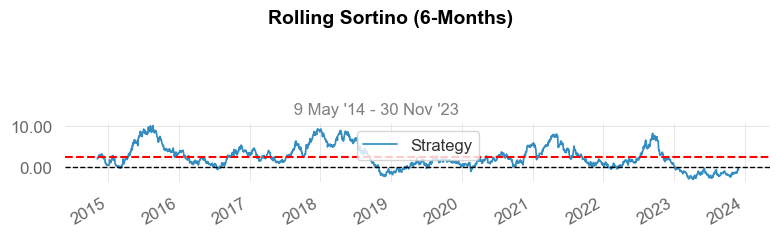

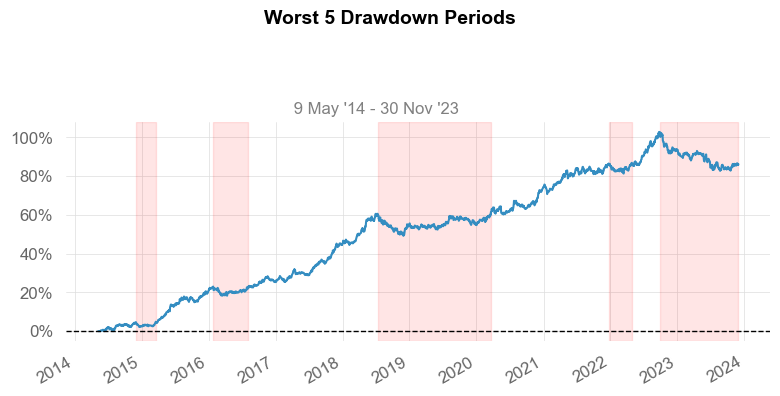

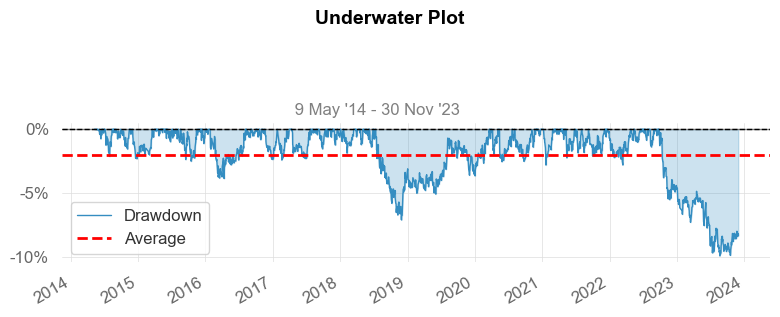

TypeError: pivot() takes 1 positional argument but 4 were given

In [13]:
alpha = eval(f'ts_rank(GrossProfitGrowthRate,252) + ts_rank(REV_G_m,252)')[small_aum_Filter]
daily_returns_財務, result_summary = bt(alpha, exp_returns,
                            strategy='LS',
                            buy_fee=0.001425*0.3, sell_fee=0.001425*0.3+0.003,
                            start_time = '2014-05-09',
                            end_time = '2023-11-30')
qs.reports.full(daily_returns_財務, Benchmark)

In [37]:
stocks = 10
result_df = result_df[small_aum_Filter]
top = result_df.apply(lambda row: row.nlargest(stocks), axis=1)#.fillna(0)
df_cleaned = top.loc['2023-11-25':'2023-11-30'].dropna(axis=1, how='all')
df_cleaned

symbol,1515,1904,2006,2233,2353,2357,2369,2376,2377,2383
2023-11-27,0.007165,0.007165,0.007165,0.007165,0.007165,0.007165,0.007165,0.007165,0.007165,0.007165
2023-11-28,0.007129,0.007129,0.007129,0.007129,0.007129,0.007129,0.007129,0.007129,0.007129,0.007129
2023-11-29,0.007042,0.007042,0.007042,0.007042,0.007042,0.007042,0.007042,0.007042,0.007042,0.007042
2023-11-30,0.007051,0.007051,0.007051,0.007051,0.007051,0.007051,0.007051,0.007051,0.007051,0.007051


In [15]:
C = daily_returns_財務.corr(daily_returns_投信)
C

0.2988297141329475

/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tedting/anaconda3/envs/quant39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass ax

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-05-09  2014-05-09
End Period                 2023-11-30  2023-11-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          50.56%      96.98%
CAGR﹪                     4.37%       7.34%

Sharpe                     1.09        0.52
Prob. Sharpe Ratio         99.96%      94.24%
Smart Sharpe               1.06        0.51
Sortino                    1.64        0.72
Smart Sortino              1.59        0.7
Sortino/√2                 1.16        0.51
Smart Sortino/√2           1.12        0.49
Omega                      1.2         1.2

Max Drawdown               -7.48%      -31.51%
Longest DD Days            615         748
Volatility (ann.)          4.13%       16.61%
R^2                        0.03        0.03
Information Ratio          -0.02       -0.02
Calmar                     0.58        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-07-12,2018-11-21,2020-03-18,615,-7.477631,-7.203685
2,2022-09-28,2023-01-31,2023-11-08,406,-4.418339,-4.106222
3,2015-08-24,2015-10-16,2015-12-09,107,-4.401640,-4.340127
4,2016-10-04,2017-02-18,2017-07-21,290,-4.142329,-3.907568
5,2020-07-27,2020-11-17,2021-07-06,344,-3.937233,-3.861031


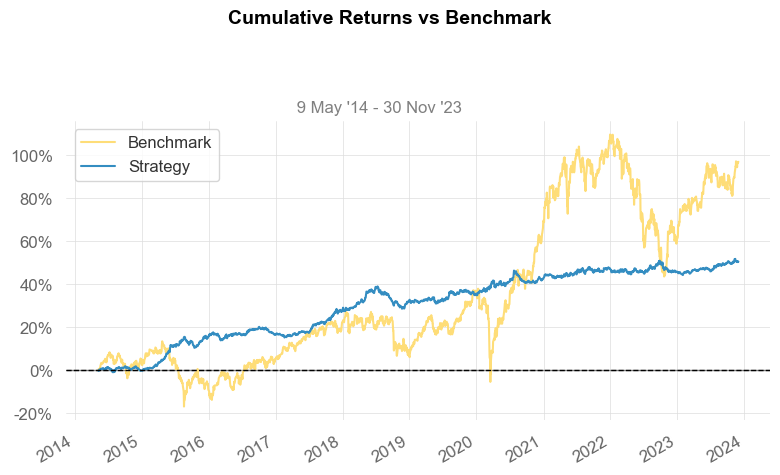

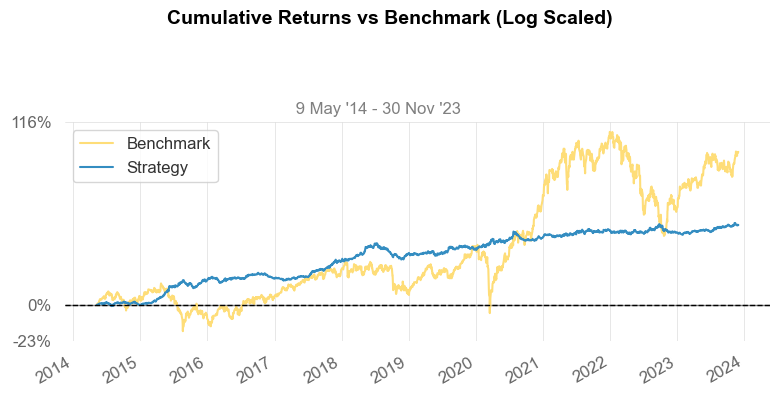

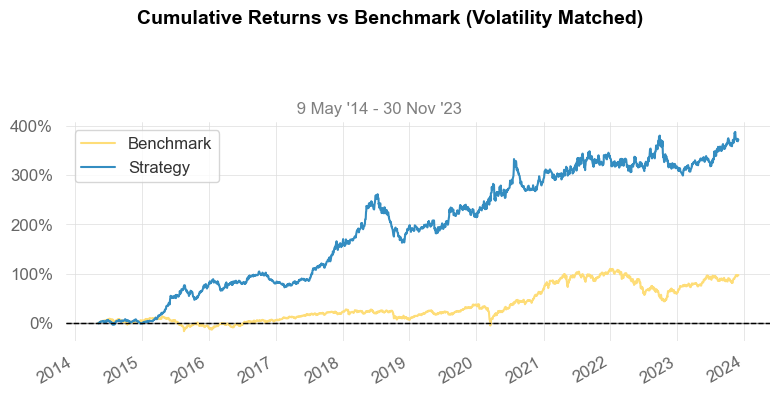

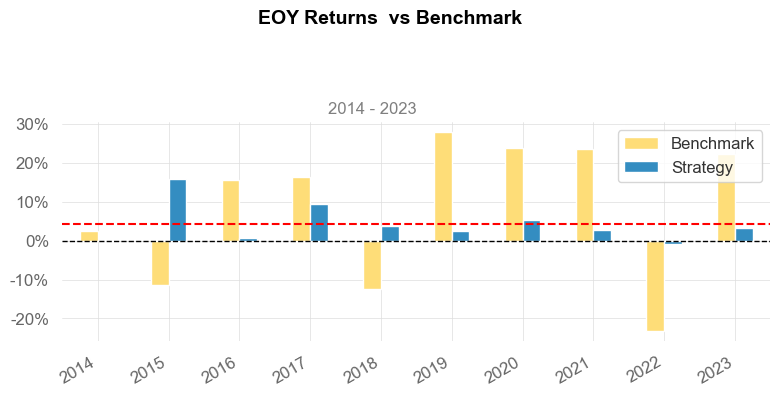

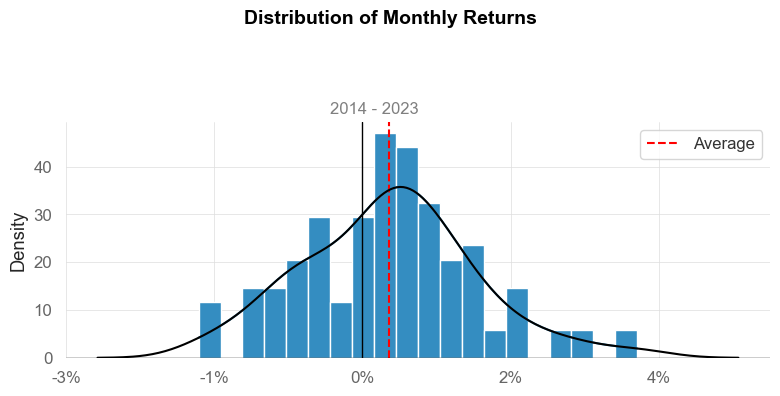

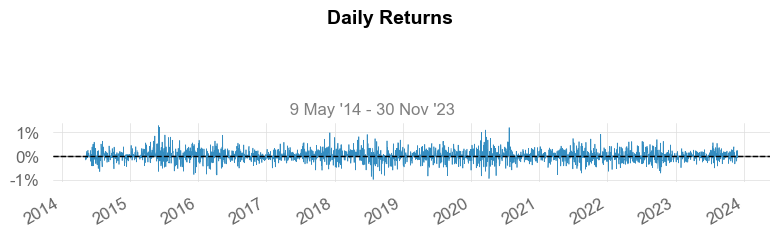

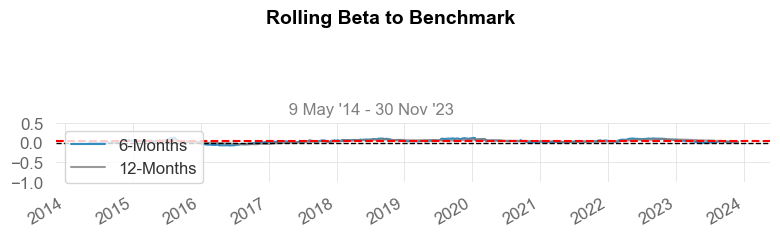

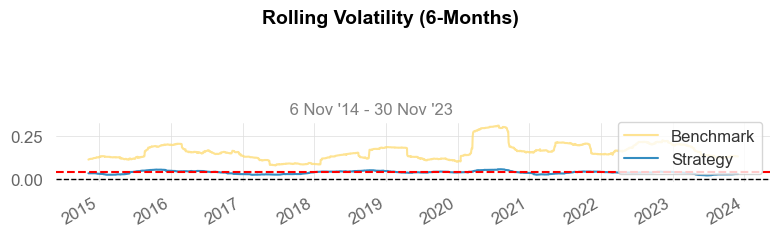

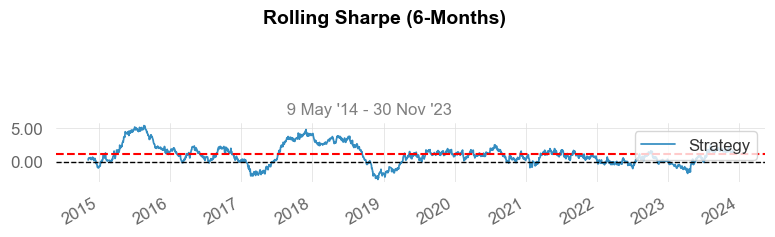

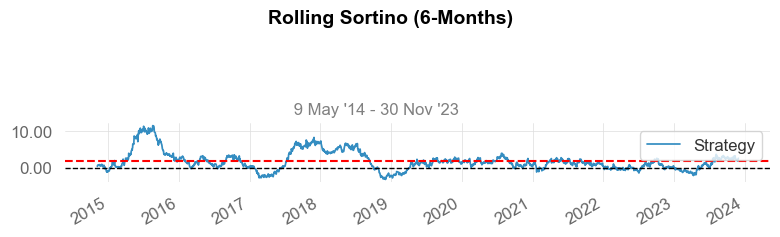

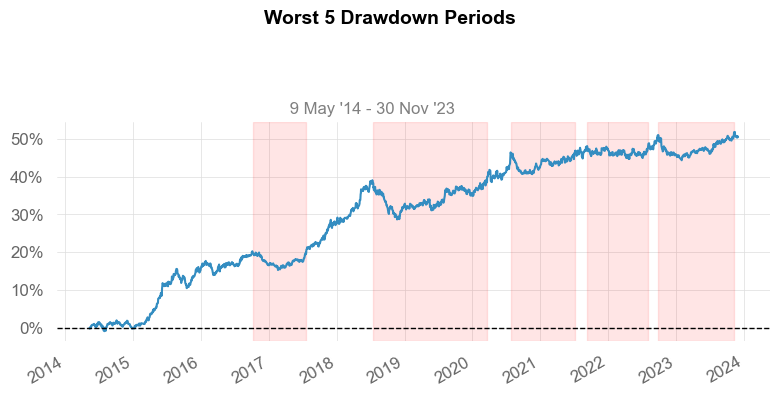

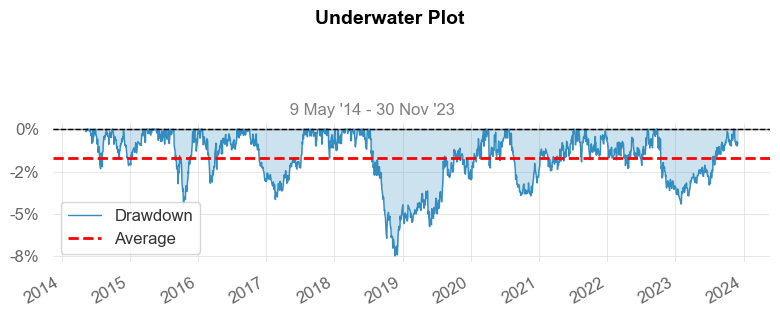

TypeError: pivot() takes 1 positional argument but 4 were given

In [16]:
qs.reports.full((daily_returns_財務 + daily_returns_投信)/2, Benchmark)

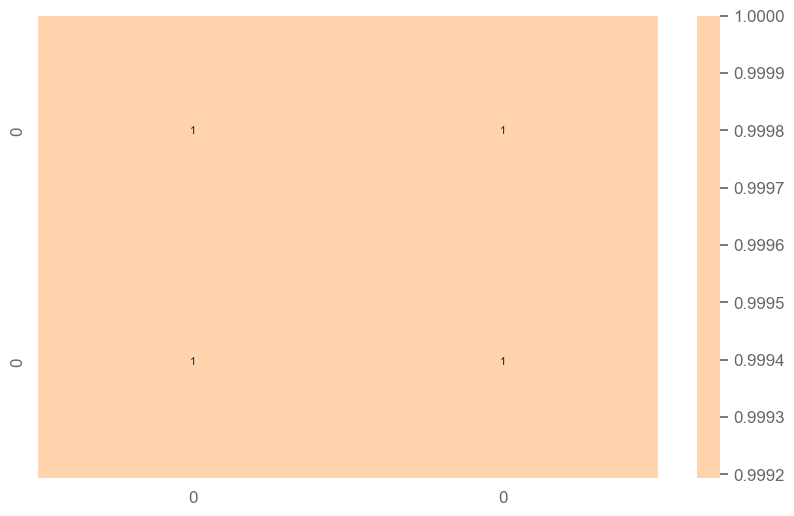

In [12]:
#correlation_matrix.columns = data_list
df_corr = correlation_matrix.corr()
sns.heatmap(df_corr, center=0, annot=True, annot_kws={"size": 8})
mp.show()